In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics
import json 
from datetime import datetime

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pickle

%matplotlib inline


In [2]:
# https://stackoverflow.com/questions/956867/how-to-get-string-objects-instead-of-unicode-from-json

def byteify(input):
    if isinstance(input, dict):
        return {byteify(key): byteify(value)
                for key, value in input.iteritems()}
    elif isinstance(input, list):
        return [byteify(element) for element in input]
    elif isinstance(input, unicode):
        return input.encode('utf-8')
    else:
        return input

In [3]:
# load csv file into Pandas dataframe table format
df = pd.read_csv('Ultimate_Users_2014.csv')

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,month_last_trip,month_signup,delta_time_last_trip_months,long_term_status
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,6,1,4.698248,lt
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,5,1,3.154069,st
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1,1,0.032855,st
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,6,1,5.585330,lt
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,3,1,1.544180,st


In [4]:
#Convert date as strings into datetime objects
# & overwrite orignial columns

df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [5]:
df.dtypes

avg_dist                              float64
avg_rating_by_driver                  float64
avg_rating_of_driver                  float64
avg_surge                             float64
city                                   object
last_trip_date                 datetime64[ns]
phone                                  object
signup_date                    datetime64[ns]
surge_pct                             float64
trips_in_first_30_days                  int64
ultimate_black_user                      bool
weekday_pct                           float64
month_last_trip                         int64
month_signup                            int64
delta_time_last_trip_months           float64
long_term_status                       object
dtype: object

In [6]:
df['month_last_trip'] = pd.DatetimeIndex(df['last_trip_date']).month

In [7]:
df.month_last_trip.value_counts()

6    18256
1    10147
5     7585
4     4588
3     4568
2     4308
7      548
Name: month_last_trip, dtype: int64

In [8]:
df['month_signup'] = pd.DatetimeIndex(df['signup_date']).month

df.month_signup.value_counts()

1    50000
Name: month_signup, dtype: int64

In [9]:
df['delta_time_last_trip_months'] = (df['last_trip_date'] - df['signup_date'])/np.timedelta64(1,'M')

In [10]:
#df[['avg_dist','trips_in_first_30_days','dist_first_30']].head(15)

## Looks like an error with the data: average distance for first 30 days should be 0 if number of trips in first 30 days is also 0

In [11]:
num_boo_boos = 0

for ind in df.index: 
    if (df['avg_dist'][ind] > 0) & (df['trips_in_first_30_days'][ind]== 0):
        num_boo_boos +=1
        #print('Distance : '+ str(df['avg_dist'][ind]))
        #print('num_of_trips : '+ str(df['trips_in_first_30_days'][ind]))
        #print
 


In [12]:
print(num_boo_boos)

15334


In [13]:
df.trips_in_first_30_days.describe()

count    50000.000000
mean         2.278200
std          3.792684
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

In [14]:
# useful link: https://towardsdatascience.com/apply-and-lambda-usage-in-pandas-b13a1ea037f7
# function imputes num of trips in first 30 days with the mean if avg distance traveled
# in first 30 days is NOT zero!
def fix_trips_first30days(avg_dist,trips_in_first_30_days): 
    if (avg_dist > 0) & (trips_in_first_30_days == 0):
        return 2.28
    else:
        return trips_in_first_30_days
        
    

In [15]:
# apply custom function
df['Trips_in_first_30'] = df.apply(lambda x: fix_trips_first30days(x['avg_dist'],x['trips_in_first_30_days']),axis=1)

In [16]:
num_boo_boos2 = 0

for ind in df.index: 
    if (df['avg_dist'][ind] > 0) & (df['trips_in_first_30_days'][ind]== 0):
        num_boo_boos +=1
        #print('Distance : '+ str(df['avg_dist'][ind]))
        #print('num_of_trips : '+ str(df['trips_in_first_30_days'][ind]))
        #print

In [17]:
print(num_boo_boos2)

0


In [18]:
df[['avg_dist','trips_in_first_30_days','Trips_in_first_30']].head(15)

,avg_dist,trips_in_first_30_days,Trips_in_first_30
0,3.67,4,4.00
1,8.26,0,2.28
2,0.77,3,3.00
3,2.36,9,9.00
4,3.13,14,14.00
5,10.56,2,2.00
6,3.95,1,1.00
7,2.04,2,2.00
8,4.36,2,2.00
9,2.37,1,1.00


In [19]:
# Engineered feature: distance traveled by user in first 30 days
df['dist_first_30'] = df.avg_dist * df.Trips_in_first_30

In [20]:
df[['avg_dist','trips_in_first_30_days','dist_first_30','Trips_in_first_30']].head(15)

,avg_dist,trips_in_first_30_days,dist_first_30,Trips_in_first_30
0,3.67,4,14.6800,4.00
1,8.26,0,18.8328,2.28
2,0.77,3,2.3100,3.00
3,2.36,9,21.2400,9.00
4,3.13,14,43.8200,14.00
5,10.56,2,21.1200,2.00
6,3.95,1,3.9500,1.00
7,2.04,2,4.0800,2.00
8,4.36,2,8.7200,2.00
9,2.37,1,2.3700,1.00


In [21]:
df.shape

(50000, 18)

In [22]:
#def long_term_or_not(delta_time):
    #if delta_time >=6:
        #return 'lt'
        #return 1
    #else:
        #return  0
        #return 'st'

In [23]:
# New function to create a category class
# if the user is still using the service in June or July they are long term ,'lt'
def long_term_or_not2(month):
    if month >=6:
        #return 'lt'
        return 1 # 1 for long term user
    else:
        return  0
        #return 'st'

In [24]:
# New function to create a category class
# if the user used Ultimate within first 30 days from signging up
def retained_or_not(trips):
    if trips > 0:
        return 1
    else:
        return 0
       

In [25]:
#df['long_term_status'] = df['delta_time_last_trip_months'].apply(long_term_or_not)
df['long_term_status'] = df['month_last_trip'].apply(long_term_or_not2)

In [26]:
#df['long_term_status'] = df['delta_time_last_trip_months'].apply(long_term_or_not)
df['retain_status'] = df['trips_in_first_30_days'].apply(retained_or_not)

In [27]:
df.columns

Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'city', u'last_trip_date', u'phone', u'signup_date',
       u'surge_pct', u'trips_in_first_30_days', u'ultimate_black_user',
       u'weekday_pct', u'month_last_trip', u'month_signup',
       u'delta_time_last_trip_months', u'long_term_status',
       u'Trips_in_first_30', u'dist_first_30', u'retain_status'],
      dtype='object')

In [28]:
df.long_term_status.value_counts()

0    31196
1    18804
Name: long_term_status, dtype: int64

In [29]:
#df.delta_time_last_trip_months.value_counts()

In [30]:
df.month_last_trip.value_counts()

6    18256
1    10147
5     7585
4     4588
3     4568
2     4308
7      548
Name: month_last_trip, dtype: int64

In [31]:
df.retain_status.value_counts()

1    34610
0    15390
Name: retain_status, dtype: int64

## ~69% of Users Are "Retained", used Ultimate within 30 days of signing up.

In [32]:
df.dtypes

avg_dist                              float64
avg_rating_by_driver                  float64
avg_rating_of_driver                  float64
avg_surge                             float64
city                                   object
last_trip_date                 datetime64[ns]
phone                                  object
signup_date                    datetime64[ns]
surge_pct                             float64
trips_in_first_30_days                  int64
ultimate_black_user                      bool
weekday_pct                           float64
month_last_trip                         int64
month_signup                            int64
delta_time_last_trip_months           float64
long_term_status                        int64
Trips_in_first_30                     float64
dist_first_30                         float64
retain_status                           int64
dtype: object

In [33]:
df.columns

Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'city', u'last_trip_date', u'phone', u'signup_date',
       u'surge_pct', u'trips_in_first_30_days', u'ultimate_black_user',
       u'weekday_pct', u'month_last_trip', u'month_signup',
       u'delta_time_last_trip_months', u'long_term_status',
       u'Trips_in_first_30', u'dist_first_30', u'retain_status'],
      dtype='object')

In [34]:
df.tail()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,month_last_trip,month_signup,delta_time_last_trip_months,long_term_status,Trips_in_first_30,dist_first_30,retain_status
49995,5.63,4.2,5.0,1.0,King's Landing,2014-06-05,iPhone,2014-01-25,0.0,0,False,100.0,6,1,4.303990,1,2.28,12.8364,0
49996,0.00,4.0,NaN,1.0,Astapor,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0,1,1,0.032855,0,1.00,0.0000,1
49997,3.86,5.0,5.0,1.0,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,True,100.0,5,1,3.646892,0,2.28,8.8008,0
49998,4.58,3.5,3.0,1.0,Astapor,2014-01-15,iPhone,2014-01-14,0.0,2,False,100.0,1,1,0.032855,0,2.00,9.1600,1
49999,3.49,5.0,NaN,1.0,Astapor,2014-04-20,Android,2014-01-18,0.0,0,False,0.0,4,1,3.022649,0,2.28,7.9572,0


In [100]:
df.city.value_counts(normalize=True)

Winterfell        0.46672
Astapor           0.33068
King's Landing    0.20260
Name: city, dtype: float64

In [35]:
df.isnull().sum()

avg_dist                          0
avg_rating_by_driver            201
avg_rating_of_driver           8122
avg_surge                         0
city                              0
last_trip_date                    0
phone                           396
signup_date                       0
surge_pct                         0
trips_in_first_30_days            0
ultimate_black_user               0
weekday_pct                       0
month_last_trip                   0
month_signup                      0
delta_time_last_trip_months       0
long_term_status                  0
Trips_in_first_30                 0
dist_first_30                     0
retain_status                     0
dtype: int64

In [36]:
#fill NA with mean() of each column in boston dataset
predictors = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver',
              'avg_surge','surge_pct','Trips_in_first_30','weekday_pct']

for pred in predictors:
    df[pred] = df[pred].fillna(df[pred].mean(),axis=0)

In [37]:
# replace nulls in phone column with the string 'Unknown'
df["phone"].fillna("Unknown", inplace = True) 

In [38]:
df.isnull().sum()

avg_dist                       0
avg_rating_by_driver           0
avg_rating_of_driver           0
avg_surge                      0
city                           0
last_trip_date                 0
phone                          0
signup_date                    0
surge_pct                      0
trips_in_first_30_days         0
ultimate_black_user            0
weekday_pct                    0
month_last_trip                0
month_signup                   0
delta_time_last_trip_months    0
long_term_status               0
Trips_in_first_30              0
dist_first_30                  0
retain_status                  0
dtype: int64

In [39]:
df.phone.value_counts()

iPhone     34582
Android    15022
Unknown      396
Name: phone, dtype: int64

In [40]:
print(np.mean(df.trips_in_first_30_days))

2.2782


In [41]:
print(np.mean(df.delta_time_last_trip_months))

3.04860797963


In [42]:
print(df.delta_time_last_trip_months.describe())

count    50000.000000
mean         3.048608
std          2.041268
min          0.000000
25%          0.887082
50%          3.614037
75%          4.928233
max          5.946734
Name: delta_time_last_trip_months, dtype: float64


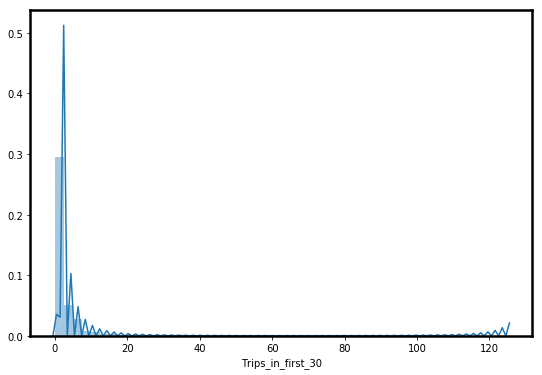

In [43]:
#sns.distplot(df.review_scores_rating)
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
sns.distplot(df.Trips_in_first_30)

In [44]:
predictors = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver',
              'avg_surge','surge_pct', 'Trips_in_first_30','weekday_pct','dist_first_30']

X = df[predictors]
y  = df.long_term_status

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

print(X_train.shape)
print
print(X_test.shape)

(40000, 8)

(10000, 8)


In [46]:
y_test.value_counts()

0    6175
1    3825
Name: long_term_status, dtype: int64

## XGBoost Classifier Optimization

In [47]:
# XGBoost Classifier

xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
print("XGBoost Classifier Score: {:.2f}".format(xgbc.score(X_test, y_test)))
print

XGBoost Classifier Score: 0.74



In [48]:
# Generate Confusion Matrix 
actual = y_test
predictions = xgbc.predict(X_test)
print('Confusion Matrix for XGBoost Model')
print
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for XGBoost Model

[[5265  910]
 [1655 2170]]


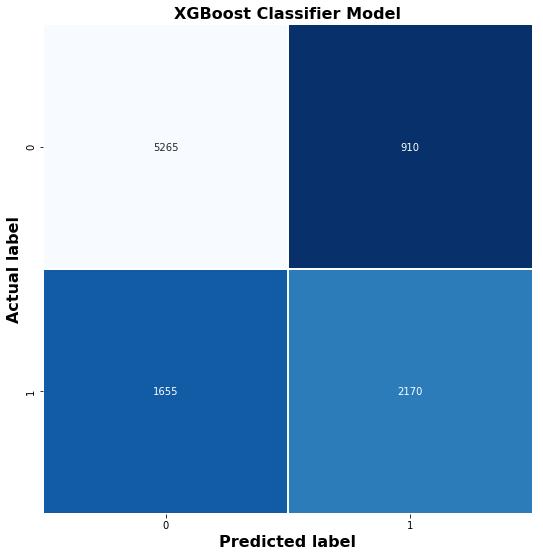

In [49]:
# Confusion matrix for XGBoost Classifier Model
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar= None);
plt.ylabel('Actual label',fontsize=16,fontweight='bold');
plt.xlabel('Predicted label',fontsize=16,fontweight='bold');
plt.title('XGBoost Classifier Model',fontsize=16,fontweight='bold');

In [50]:
# optimize number of estimators
num_estimators = [100,200,300,400,500,600,700,800,900,1000]

for num_est in num_estimators:
    
    xgbc_opt = XGBClassifier(n_estimators= num_est)
    xgbc_opt.fit(X_train, y_train)
    print("XGBoost Classifier Score: {:.2f}".format(xgbc_opt.score(X_test, y_test)))
    print

XGBoost Classifier Score: 0.74

XGBoost Classifier Score: 0.74

XGBoost Classifier Score: 0.75

XGBoost Classifier Score: 0.75

XGBoost Classifier Score: 0.75

XGBoost Classifier Score: 0.75

XGBoost Classifier Score: 0.75

XGBoost Classifier Score: 0.75

XGBoost Classifier Score: 0.75

XGBoost Classifier Score: 0.75



## Enhanced Data Features for Prediction

In [51]:
X = df.drop(['long_term_status','city','phone','last_trip_date','signup_date','month_last_trip',\
              'delta_time_last_trip_months','trips_in_first_30_days'],axis=1)

# target variable
y  = df.long_term_status

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

print(X_train.shape)
print
print(X_test.shape)

(40000, 11)

(10000, 11)


In [52]:
X.columns

Index([u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver',
       u'avg_surge', u'surge_pct', u'ultimate_black_user', u'weekday_pct',
       u'month_signup', u'Trips_in_first_30', u'dist_first_30',
       u'retain_status'],
      dtype='object')

In [53]:
%%time
xgbc_2 = XGBClassifier()
xgbc_2.fit(X_train, y_train)
print("XGBoost Classifier Score: {:.2f}".format(xgbc_2.score(X_test, y_test)))
print

XGBoost Classifier Score: 0.75

CPU times: user 3.41 s, sys: 12.2 ms, total: 3.42 s
Wall time: 3.42 s


In [54]:
print(xgbc_2.get_params())

{'reg_alpha': 0, 'n_jobs': 1, 'colsample_bytree': 1, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'missing': None, 'max_delta_step': 0, 'nthread': None, 'base_score': 0.5, 'n_estimators': 100, 'subsample': 1, 'reg_lambda': 1, 'random_state': 0, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed': None, 'max_depth': 3, 'gamma': 0, 'booster': 'gbtree'}


In [55]:
# Generate Confusion Matrix for XGBoost Model with enhanced features
actual = y_test
predictions = xgbc_2.predict(X_test)
print('Confusion Matrix for XGBoost Model')
print
cm_xgb2 = confusion_matrix(actual,predictions)
print(cm_xgb2)

Confusion Matrix for XGBoost Model

[[5370  825]
 [1641 2164]]


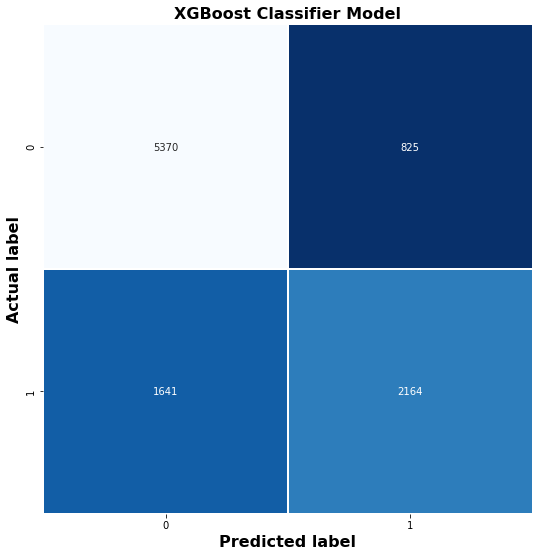

In [56]:
# Confusion matrix for XGBoost Classifier Model
plt.figure(figsize=(9,9))
sns.heatmap(cm_xgb2, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar= None);
plt.ylabel('Actual label',fontsize=16,fontweight='bold');
plt.xlabel('Predicted label',fontsize=16,fontweight='bold');
plt.title('XGBoost Classifier Model',fontsize=16,fontweight='bold');

In [57]:
xgbc_prediction_2 = xgbc_2.predict(X_test)
print(classification_report(xgbc_prediction_2, y_test))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81      7011
           1       0.57      0.72      0.64      2989

   micro avg       0.75      0.75      0.75     10000
   macro avg       0.72      0.74      0.73     10000
weighted avg       0.78      0.75      0.76     10000



In [58]:
# optimize number of estimators
num_estimators = [100,200,300,400,500,600,700,800,900,1000]

#for num_est in num_estimators:
    
    #xgbc_opt2 = XGBClassifier(n_estimators= num_est)
    #xgbc_opt2.fit(X_train, y_train)
    #print(num_est)
    #print("XGBoost Classifier Score: {:.2f}".format(xgbc_opt2.score(X_test, y_test)))
    #print

## Grid Search with XGBoost Classifier

In [59]:
# truncated dataframe using df.sample
df_trunc = df.drop(['city','phone','last_trip_date','signup_date','month_last_trip',\
              'delta_time_last_trip_months','trips_in_first_30_days'],axis=1)

df_trunc = df_trunc.sample(frac=0.25)

df_trunc.shape

(12500, 12)

In [60]:
df_trunc.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,month_signup,long_term_status,Trips_in_first_30,dist_first_30,retain_status
29033,1.32,5.0,5.0,1.00,0.0,False,0.0,1,0,1.00,1.3200,1
49724,8.24,5.0,4.8,1.00,0.0,True,50.0,1,1,4.00,32.9600,1
39654,6.39,5.0,4.5,1.00,0.0,False,100.0,1,0,2.28,14.5692,0
38466,3.59,4.4,4.6,1.01,3.2,True,48.4,1,1,3.00,10.7700,1
30998,2.08,5.0,4.9,1.13,20.0,True,50.0,1,1,1.00,2.0800,1


In [61]:
df_trunc.long_term_status.value_counts()

0    7816
1    4684
Name: long_term_status, dtype: int64

In [62]:
df_trunc.long_term_status.value_counts(normalize=True)

0    0.62528
1    0.37472
Name: long_term_status, dtype: float64

In [63]:
# create new train & test data sets using truncated data
X = df_trunc.drop(['long_term_status'],axis=1)

# target variable
y  = df_trunc.long_term_status

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

print(X_train.shape)
print
print(X_test.shape)

(10000, 11)

(2500, 11)


In [64]:
y_test.value_counts(normalize=True)

0    0.6436
1    0.3564
Name: long_term_status, dtype: float64

In [65]:
# Create a parameter grid to search over
param_grid = {
              'max_depth': [3,5,10, 20, 30, 40, 50],
              'n_estimators': [100,200, 400,500,600]}

xgbc_op = XGBClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgbc_op, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

print(grid_search.best_params_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 10.1min finished


{'n_estimators': 200, 'max_depth': 3}


In [66]:
# grid search results
# {'max_depth': 5}
#{'n_estimators': 400}

In [67]:
xgbc_3 = XGBClassifier(max_depth= 5,n_estimators= 100)
xgbc_3.fit(X_train, y_train)
print("XGBoost Classifier Score: {:.2f}".format(xgbc_3.score(X_test, y_test)))
print

XGBoost Classifier Score: 0.76



In [68]:
# Generate Confusion Matrix for XGBoost Model with enhanced features
actual = y_test
predictions = xgbc_3.predict(X_test)
print('Confusion Matrix for XGBoost Model')
print
cm_xgb3 = confusion_matrix(actual,predictions)
print(cm_xgb3)

Confusion Matrix for XGBoost Model

[[1372  237]
 [ 353  538]]


In [69]:
xgbc_prediction_3 = xgbc_3.predict(X_test)
print(classification_report(xgbc_prediction_3, y_test))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      1725
           1       0.60      0.69      0.65       775

   micro avg       0.76      0.76      0.76      2500
   macro avg       0.73      0.74      0.73      2500
weighted avg       0.78      0.76      0.77      2500



## Randomized Search CV

In [70]:
# https://github.com/krishnaik06/Hyperparameter-Optimization/blob/master/Hyperparameter%20Optimization%20For%20Xgboost.ipynb
# See useful link above from Krish Naik
# see youtube video on this link  https://www.youtube.com/watch?v=9HomdnM12o4

In [71]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [72]:
classifier= XGBClassifier()

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=3,verbose=3)

In [73]:
random_search.fit(X,y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   10.2s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'colsample_bytree': [0.3, 0.4, 0.5, 0.7], 'max_depth': [3, 4, 5, 6, 8, 10, 12, 15], 'min_child_weight': [1, 3, 5, 7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)

In [74]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0.2, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [75]:
random_search.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.2,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5}

In [76]:
# use full data for training & test sets
X = df.drop(['long_term_status','city','phone','last_trip_date','signup_date','month_last_trip',\
              'delta_time_last_trip_months','trips_in_first_30_days'],axis=1)

# target variable
y  = df.long_term_status

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

print(X_train.shape)
print
print(X_test.shape)

(40000, 11)

(10000, 11)


In [77]:
{'reg_alpha': 0, 'n_jobs': 1, 'colsample_bytree': 1, 'silent': True, 'colsample_bylevel': 1, 
 'scale_pos_weight': 1, 'learning_rate': 0.1, 'missing': None, 'max_delta_step': 0, 'nthread': None, 
 'base_score': 0.5, 'n_estimators': 100, 'subsample': 1, 'reg_lambda': 1, 'random_state': 0, 'min_child_weight': 1,
 'objective': 'binary:logistic', 'seed': None, 'max_depth': 3, 'gamma': 0, 'booster': 'gbtree'}

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [78]:
xgbc_op = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=0.3, gamma=0.2, learning_rate=0.15,
                        max_delta_step=0, max_depth=5, min_child_weight=3, missing=None,
                        n_estimators=100, n_jobs=1, nthread=None,
                        objective='binary:logistic', random_state=0, reg_alpha=0,
                        reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                        subsample=1)


xgbc_op.fit(X_train, y_train)
print("XGBoost Classifier Score: {:.2f}".format(xgbc_3.score(X_test, y_test)))
print

XGBoost Classifier Score: 0.76



In [79]:
# Generate Confusion Matrix for XGBoost Model with enhanced features
actual = y_test
predictions = xgbc_op.predict(X_test)
print('Confusion Matrix for Random Search Optimized XGBoost Model')
print
cm_xgbc_op = confusion_matrix(actual,predictions)
print(cm_xgbc_op)

Confusion Matrix for Random Search Optimized XGBoost Model

[[5423  831]
 [1599 2147]]


In [80]:
xgbc_op2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bytree=0.3, gamma=0.3, learning_rate=0.15,
                        max_delta_step=0, max_depth=6, min_child_weight=3, missing=None,
                        n_estimators= 100, n_jobs=1, nthread=None,
                        objective='binary:logistic', random_state=0, reg_alpha=0,
                        reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                        subsample=1)


xgbc_op2.fit(X_train, y_train)
print("XGBoost Classifier Score: {:.2f}".format(xgbc_op2.score(X_test, y_test)))
print

XGBoost Classifier Score: 0.75



In [81]:
# Generate Confusion Matrix for XGBoost Model with enhanced features
actual = y_test
predictions_2 = xgbc_op2.predict(X_test)
print('Confusion Matrix for Random Search Optimized XGBoost Model')
print
cm_xgbc_op2 = confusion_matrix(actual,predictions_2)
print(cm_xgbc_op2)

Confusion Matrix for Random Search Optimized XGBoost Model

[[5382  872]
 [1590 2156]]


## gamma of 0.3 seems to give best result in predicting long term status, 1, of Ultimate users

In [82]:
xgbc_un_op = XGBClassifier()


xgbc_un_op.fit(X_train, y_train)
print("XGBoost Classifier Score: {:.2f}".format(xgbc_un_op.score(X_test, y_test)))
print

XGBoost Classifier Score: 0.75



In [83]:
# Generate Confusion Matrix for XGBoost Model with enhanced features
actual = y_test
predictions = xgbc_un_op.predict(X_test)
print('Confusion Matrix for Random Search Optimized XGBoost Model')
print
cm_xgbc_un_op = confusion_matrix(actual,predictions)
print(cm_xgbc_un_op)

Confusion Matrix for Random Search Optimized XGBoost Model

[[5383  871]
 [1620 2126]]


Text(0,0.5,'Feature')

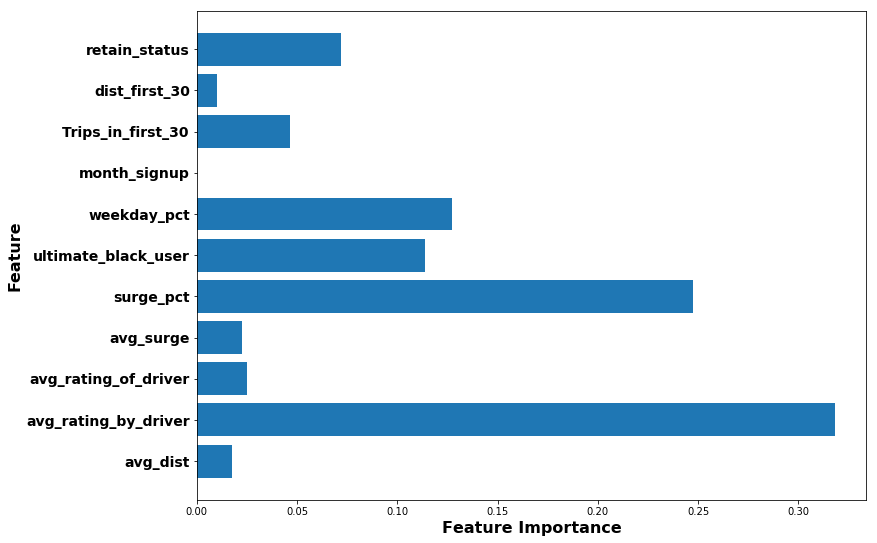

In [99]:
n_features = X.shape[1]

#plt.figure(figsize=(9,6))
plt.figure(figsize=(12,9))
plt.barh(range(n_features),xgbc_un_op.feature_importances_, align='center')
plt.yticks(np.arange(n_features),X.columns,fontsize=14,fontweight='bold')

plt.xlabel('Feature Importance',fontsize=16,fontweight='bold')
plt.ylabel('Feature',fontsize=16,fontweight='bold')
#plt.savefig('XGBoost_Op_Feature_Importances.png')